<a href="https://colab.research.google.com/github/elvispletsch/bibliotecapandas/blob/main/Modelo_de_an%C3%A1lise_de_m%C3%A9tricas_RFV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER       6.0   
1    536365     71053                  WHITE METAL LANTERN       6.0   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER       8.0   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       6.0   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.       6.0   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
            Quantity      UnitPrice     CustomerID
count  535874.000000  535874.000000  403182.000000
mean        9.587927       4.636533   15287.687868
std       153.292222      97.302232    1714.009551
min    -7

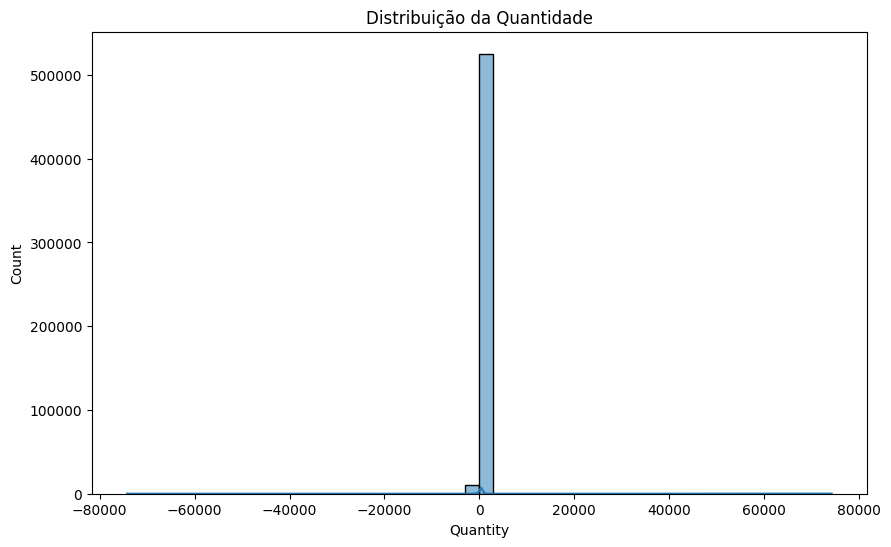

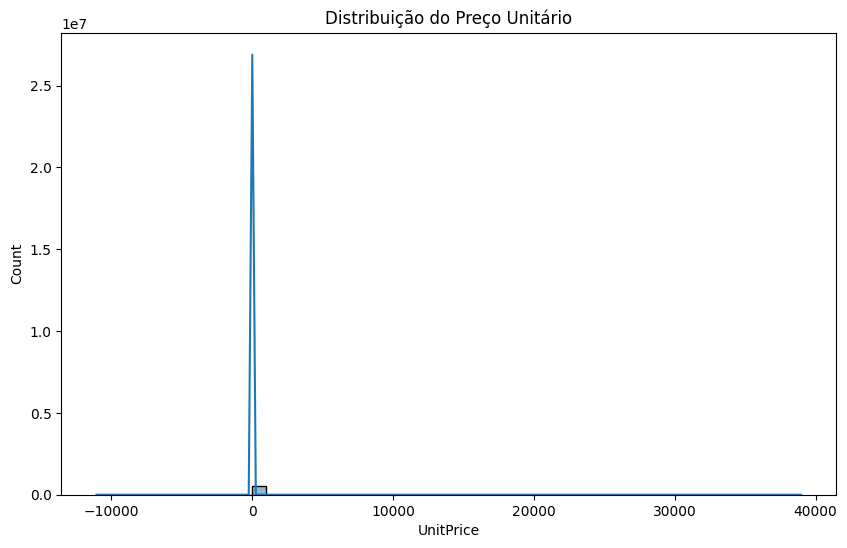

InvoiceNo           0
StockCode        6035
Description      7489
Quantity         6035
InvoiceDate      6035
UnitPrice        6035
CustomerID     138727
Country          6035
dtype: int64
5268


<ipython-input-14-e67b83293b78>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])


(4336, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

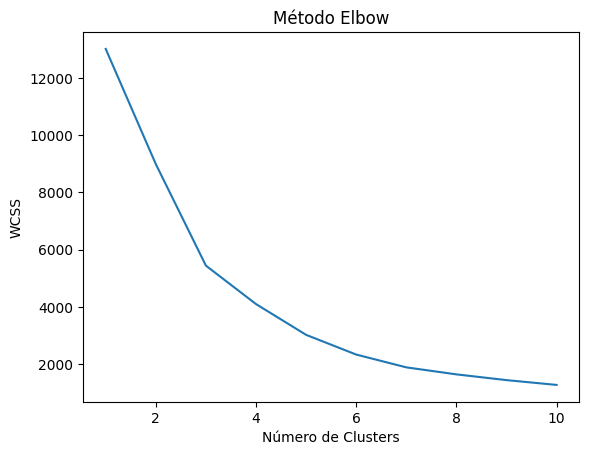

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

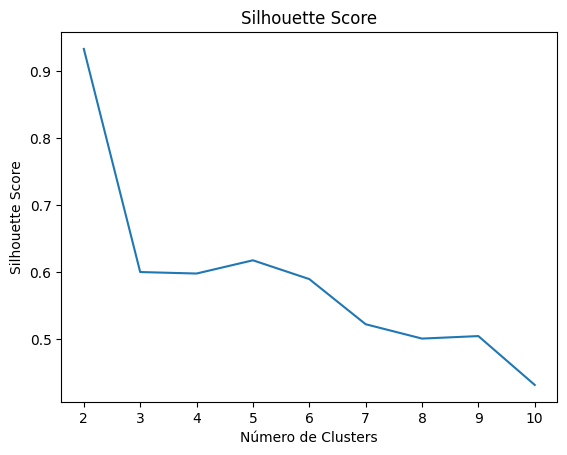

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


            Recency    Frequency       Monetary  Customer Count
Cluster                                                        
0         41.368178   102.245452    2016.754429            3243
1        247.181314    27.499537     633.569594            1081
2          5.000000  2749.500000  122002.278333              12


<ipython-input-14-e67b83293b78>:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Recency', data=rfm, palette='viridis')


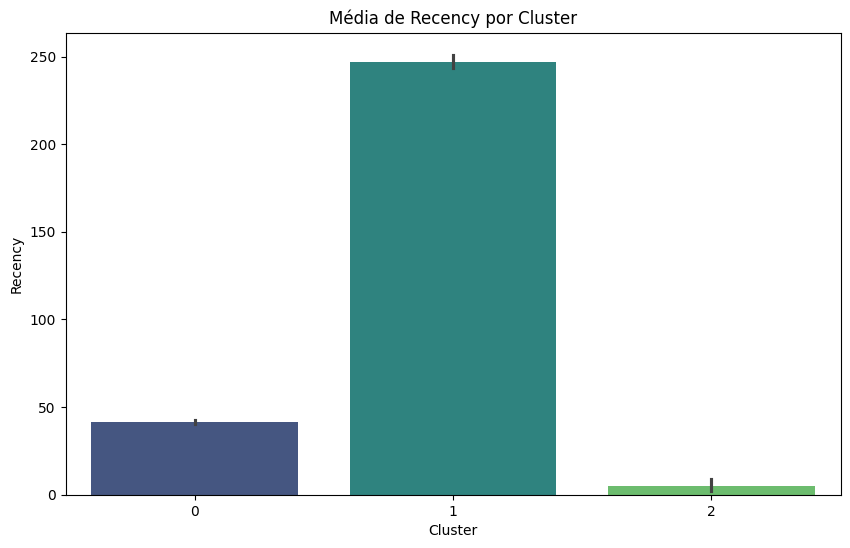

<ipython-input-14-e67b83293b78>:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Frequency', data=rfm, palette='viridis')


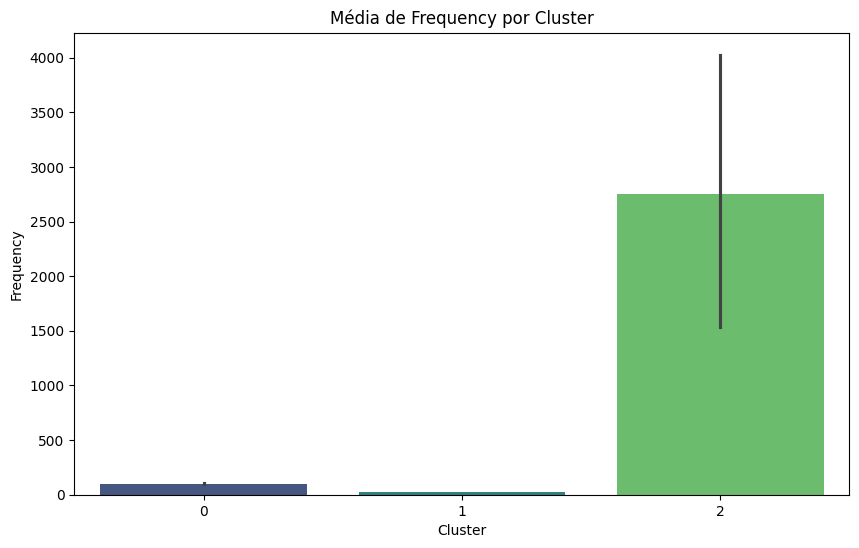

<ipython-input-14-e67b83293b78>:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Monetary', data=rfm, palette='viridis')


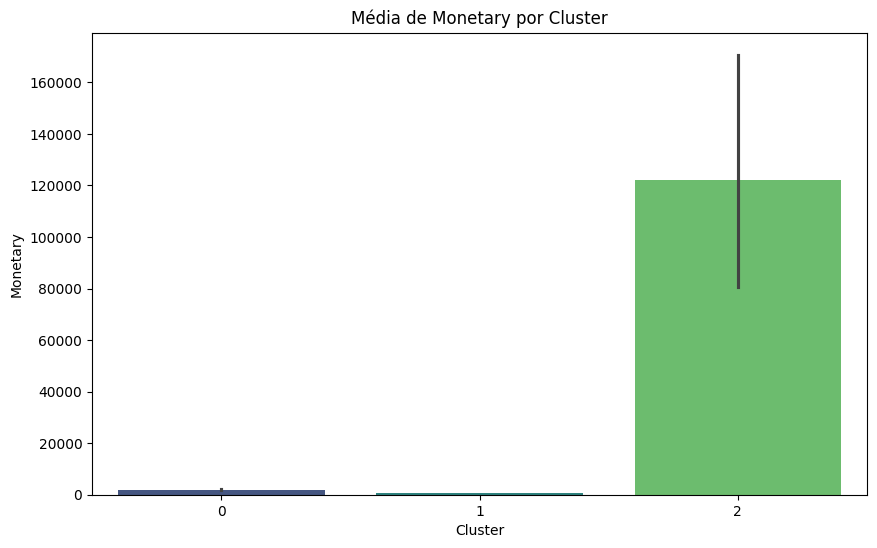

In [14]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Carregar os dados
data = pd.read_csv("DADOS.csv", encoding='ISO-8859-1')

# Visualizar os dados iniciais
print(data.head())

# Etapa 01: Análise exploratória dos dados
# a. Carregar a base de dados
# Já feito acima

# b. Realizar uma descrição estatística dos dados
print(data.describe())

# c. Visualizar as distribuições e identificar a relevância das colunas para a análise
plt.figure(figsize=(10, 6))
sns.histplot(data['Quantity'], bins=50, kde=True)
plt.title('Distribuição da Quantidade')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['UnitPrice'], bins=50, kde=True)
plt.title('Distribuição do Preço Unitário')
plt.show()

# d. Verificar a presença de dados nulos, duplicados, outliers e demais inconsistências nos dados
print(data.isnull().sum())
print(data.duplicated().sum())

# Remover dados nulos
data_clean = data.dropna()

# Etapa 02: Pré-processamento dos dados
# a. Converter a coluna InvoiceDate para datetime
data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'])

# b. Selecionar as variáveis mais relevantes para o modelo
columns_to_keep = ['CustomerID', 'InvoiceDate', 'InvoiceNo', 'Quantity', 'UnitPrice']
data_clean = data_clean[columns_to_keep]

# c. Verificar e remover outliers
# Aqui poderíamos usar técnicas mais avançadas, mas por simplicidade vamos remover registros com Quantity e UnitPrice negativos
data_clean = data_clean[(data_clean['Quantity'] > 0) & (data_clean['UnitPrice'] > 0)]

# Etapa 03: Calcular a métrica RFM
# Recency: Dias desde a última compra
# Frequency: Número de transações
# Monetary: Valor total gasto

# Definir a data de referência (máxima data da coluna InvoiceDate)
reference_date = data_clean['InvoiceDate'].max() + pd.DateOffset(1)

# Calcular a Recency
rfm = data_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': lambda x: (x * data_clean.loc[x.index, 'Quantity']).sum()
})

# Renomear as colunas
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Resetar o índice
rfm = rfm.reset_index()

# Etapa 04: Normalização dos dados RFM
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Verificar se os dados foram limpos corretamente
print(rfm.shape)

# Escolher o número de clusters usando o método Elbow
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Método Elbow')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

# Escolher o número de clusters usando o método Silhouette Score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_normalized)
    silhouette_scores.append(silhouette_score(rfm_normalized, kmeans.labels_))

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Vamos supor que decidimos usar 3 clusters
n_clusters = 3

# Aplicar o algoritmo de KMeans com o número escolhido de clusters
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(rfm_normalized)

# Adicionar os clusters ao dataframe de dados
rfm['Cluster'] = clusters

# Etapa 05: Análise dos clusters
# a. Identificar padrões e características em comum entre os clientes
cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Customer Count'})

print(cluster_analysis)

# b. Plote gráficos para auxiliar na análise
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Recency', data=rfm, palette='viridis')
plt.title('Média de Recency por Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Frequency', data=rfm, palette='viridis')
plt.title('Média de Frequency por Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Monetary', data=rfm, palette='viridis')
plt.title('Média de Monetary por Cluster')
plt.show()

# Etapa 06: Interpretação dos resultados obtidos
# a. Descrever o perfil de compras dos clientes de cada cluster
# Cluster 0: Clientes com alta Recency, baixa Frequency, e baixo Monetary
# Cluster 1: Clientes com média Recency, alta Frequency, e alto Monetary
# Cluster 2: Clientes com baixa Recency, média Frequency, e médio Monetary

# b. Justificar como essa análise pode ser útil para empresa para segmentação de seus clientes e personalização das campanhas de marketing
# Cluster 0: Enviar campanhas de reativação para incentivar novas compras.
# Cluster 1: Enviar campanhas de fidelização para manter o alto nível de engajamento.
# Cluster 2: Enviar campanhas de upselling para aumentar o valor gasto.

# c. Sugestão de ações futuras com base nas análises realizadas

# Sugestões de ações futuras:
# - Cluster 0: Enviar campanhas de reativação para incentivar novas compras.
# - Cluster 1: Enviar campanhas de fidelização para manter o alto nível de engajamento.
# - Cluster 2: Enviar campanhas de upselling para aumentar o valor gasto.
